### Importing packages

#### Others

In [1]:
# Used to read the data file
import pandas as pd

# Used in the definition of the model and its initial condition
import numpy as np

# Used for plots other than those generated by the parameter estimation module
import matplotlib.pyplot as plt
%matplotlib inline

#### The module itself

In [2]:
import PDEparams as pde

### Defining the model

We use the Fisher-KPP equation defined by
$$\begin{align}
\frac{\partial u}{\partial t} &= D \frac{\partial^2 u}{\partial x^2} + r\,u(1-u)
\end{align}$$

with parameters $D$ and $r$.

#### Boundary conditions

We use no-flux boundary conditions in the domain defined by the data, *i.e.*,

$$\frac{\partial u}{\partial x} = 0$$

at the boundaries.

#### Second-order derivatives of $u$

In practice, if we consider $u$ to be a discrete 1D vector $(u_0, u_1, ...)$, then we can obtain the central differences

$$\begin{align}
h\, u'_i &= u_{i+1}-u_{i-1}\\
h^2\, u''_i &= u_{i+1}+u_{i-1}-2u_i
\end{align}$$

where $h=dx$, $u' = \partial u/\partial x$, and $u'' = \partial^2 u/\partial x^2$. If we have a boundary condition $u'_0 = 0$, and we take an imaginary point $u_{-1}$ to the left of our domain so that

$$h^2\, u''_0 = u_{1}+u_{-1}-2u_0$$

at the boundary, we obtain from the first-order difference $u_{-1} = u_1$. Therefore, in our case

$$\begin{align}h^2u''_0 &= 2u_1 - 2u_0
\end{align}$$

In [3]:
def Fisher(u, t, x, D, r):
    '''The input u corresponds to the current state of the system, and it's a vector of values u(x). Since
    the input is in 1D, no pre-processing is needed.
    
    t is the current time.
    
    x is the spatial grid of the model.

    D and r correspond to the unknown parameters.
    '''
    
    # We compute step in x
    dx = x[1]-x[0]
    
    # We initialise the spatial derivatives we need as empty arrays of the same shape of our variable
    dudxx = np.empty_like(u)

    # Second-order derivative
    
    # Left boundary. In the grid array, first element: [0]
    dudxx[0] = (2.0*u[1] - 2.0*u[0])/dx**2
    
    # Away from the x-boundary. In the grid array, second to penultimate elements: [1:-1]
    # np.diff(array, order) is used to compute 2nd-order differences
    dudxx[1:-1] = np.diff(u,2)/dx**2
    
    # Right boundary. In the grid array, last element: [-1]
    dudxx[-1] = (2.0*u[-2] - 2.0*u[-1])/dx**2
    
    # Adding the second term
    # We use np.maximum() to force the values of ru(1-u) to be non-negative and avoid small numerical errors
    
    dudt = D*dudxx + np.maximum(r*u*(1-u),0)
    
    return dudt

Here we specify the function that defines the initial condition for $u$ which, when generating the data, has been set to $u=1$ for $x<-0.3$ and $u=0$ otherwise.

In [4]:
def initfunc(x):
    return 1.*int(x<-0.3)

### Using `PDEparams` to estimate parameters

First, we load the data from the `.csv` file.

The data consist of 3 replicates, and have been generated using parameter values $D=0.1$, $r=5$.

The columns are, in order: $t$, $x$, $u$.

In [5]:
df = pd.read_csv('FisherData.csv')

df.head()

,0,1,2
0,0.075758,-0.479798,0.911668
1,0.075758,-0.479798,0.914364
2,0.075758,-0.479798,0.911544
3,0.075758,-0.429293,0.865805
4,0.075758,-0.429293,0.866684


#### Constructing the `PDEmodel` object.

The inputs are

**Required:**
1. The data table `df`.
2. The model `Fisher`.
3. The list of initial condition functions. In this case, a list of one element.
4. The bounds for the parameter values.

**Optional:**
1. The parameter names.
2. The number of variables: 1.
3. The number of spatial dimensions: 1.
4. The number of replicates in the data: 3. **(Default is 1, this needs to be provided in this case)**
5. The indices of the measured variables. In this case, the default `None`, since we have only one variable.
6. The function to apply to the output. In this case, the default `None`, since our data is directly $u$.

In [6]:
my_model = pde.PDEmodel(df, Fisher, [initfunc], bounds=[(0.01, 0.2), (4,6)], 
                        param_names=[r'$D$', r'$r$'], nvars=1, ndims=1, nreplicates=3, obsidx=None, outfunc=None)

Let us plot the initial condition.

Text(0, 0.5, '$u(x,t=0)$')

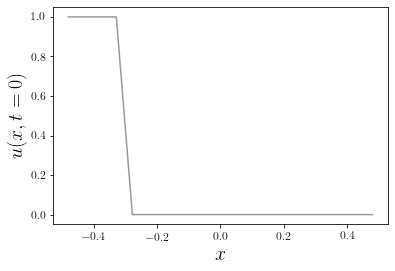

In [7]:
plt.plot(my_model.space, my_model.initial_condition)
plt.xlabel(r'$x$')
plt.ylabel(r'$u(x,t=0)$')

#### Finding the best fit parameters.

In [8]:
%%time
my_model.fit()

        $D$     $r$
0  0.094684  5.1056
CPU times: user 19.8 s, sys: 12.1 s, total: 32 s
Wall time: 21.5 s


In [9]:
my_model.best_params

,$D$,$r$
0,0.094684,5.1056


In [10]:
my_model.best_error

3.515106675704532e-05

#### Likelihood profiles

We use the default grid of 100 points per parameter.

**Note:** if you see a "widget not found" message, just ignore it; a progress bar will appear when you run the cell below.

In [17]:
%%time
my_model.likelihood_profiles()


CPU times: user 30min 54s, sys: 27min 55s, total: 58min 50s
Wall time: 31min 27s


The raw results

In [18]:
my_model.result_profiles

,parameter,value,error
0,$D$,0.010000,0.164802
1,$D$,0.011919,0.144492
2,$D$,0.013838,0.125980
3,$D$,0.015758,0.109224
4,$D$,0.017677,0.094326
5,$D$,0.019596,0.081308
6,$D$,0.021515,0.070059
7,$D$,0.023434,0.060386
8,$D$,0.025354,0.052074
9,$D$,0.027273,0.044923


Visualisation

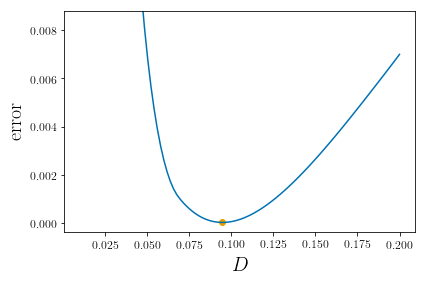

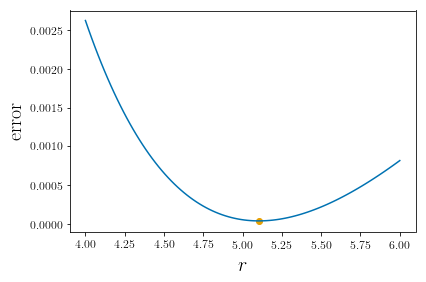

In [19]:
my_model.plot_profiles()

#### Bootstrapping

We use the default 100 repetitions.

**Note:** if you see a "widget not found" message, just ignore it; a progress bar will appear when you run the cell below.

In [20]:
%%time
my_model.bootstrap()


              $D$         $r$
count  100.000000  100.000000
mean     0.094740    5.103248
std      0.000064    0.002262
min      0.094536    5.096778
25%      0.094699    5.101904
50%      0.094747    5.103201
75%      0.094784    5.104362
max      0.094897    5.109668
CPU times: user 28min, sys: 28min 45s, total: 56min 45s
Wall time: 27min 28s


The summary

In [21]:
my_model.bootstrap_summary

,$D$,$r$
count,100.000000,100.000000
mean,0.094740,5.103248
std,0.000064,0.002262
min,0.094536,5.096778
25%,0.094699,5.101904
50%,0.094747,5.103201
75%,0.094784,5.104362
max,0.094897,5.109668


The raw results

In [22]:
my_model.bootstrap_raw

,$D$,$r$
0,0.094666,5.105857
1,0.094802,5.101306
2,0.094698,5.104337
3,0.094710,5.104589
4,0.094795,5.101503
5,0.094731,5.103505
6,0.094798,5.102691
7,0.094744,5.103123
8,0.094751,5.102683
9,0.094750,5.103047


Visualisation

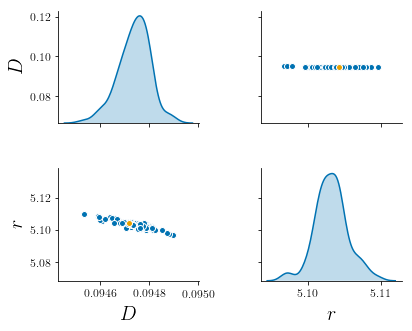

In [23]:
my_model.plot_bootstrap()

### Only a function of the variables is observed

Now we consider the case when it's not the raw outputs of the system that are observed, but rather a function of them. In this case, let us assume that the observed quantity is

$$\mathcal{F}(u) = u(1-u)$$

In [24]:
df2 = df[df.columns[[0,1]]] # we take only the space-time coordinates

# We add the new function
df2[r'$\mathcal{F}$'] = df['2']-df['2']*df['2'] # u is column 2 in the data table

df2.head()

,0,1,$\mathcal{F}$
0,0.075758,-0.479798,0.080530
1,0.075758,-0.479798,0.078302
2,0.075758,-0.479798,0.080632
3,0.075758,-0.429293,0.116187
4,0.075758,-0.429293,0.115543


#### Constructing the `PDEmodel` object.

The inputs are the same as before, except for the data&mdash;now `df2`&mdash;and `outfunc`, which specifies the function to be applied to the outputs before computing the error.

In [25]:
def F(z):
    return z*(1-z)

In [26]:
my_model2 = pde.PDEmodel(df2, Fisher, [initfunc], bounds=[(0.01, 0.2), (4,6)], 
                         param_names=[r'$D$', r'$r$'], nvars=1, ndims=1, nreplicates=3, obsidx=None, outfunc=F)

#### Finding the best fit parameters.

In [27]:
%%time
my_model2.fit()

        $D$       $r$
0  0.094969  5.083631
CPU times: user 16.8 s, sys: 18.5 s, total: 35.3 s
Wall time: 16.1 s


In [28]:
my_model2.best_params

,$D$,$r$
0,0.094969,5.083631


In [29]:
my_model2.best_error

1.3675800592789573e-05

#### Likelihood profiles

**Note:** if you see a "widget not found" message, just ignore it; a progress bar will appear when you run the cell below.

In [30]:
%%time
my_model2.likelihood_profiles()


CPU times: user 26min 57s, sys: 24min 53s, total: 51min 50s
Wall time: 24min 40s


The raw results

In [31]:
my_model2.result_profiles

,parameter,value,error
0,$D$,0.010000,0.014846
1,$D$,0.011919,0.014109
2,$D$,0.013838,0.013432
3,$D$,0.015758,0.012794
4,$D$,0.017677,0.012112
5,$D$,0.019596,0.011336
6,$D$,0.021515,0.010480
7,$D$,0.023434,0.009585
8,$D$,0.025354,0.008694
9,$D$,0.027273,0.007834


Visualisation

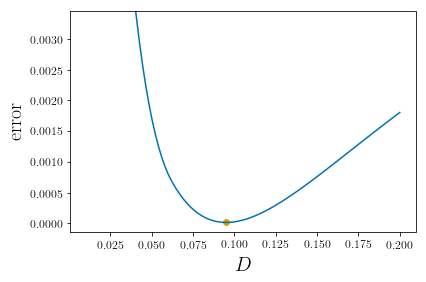

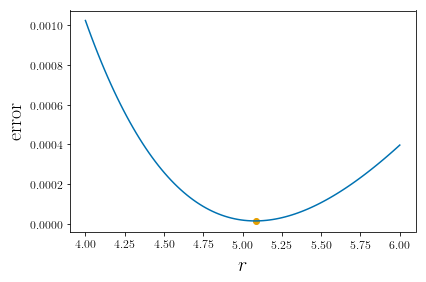

In [32]:
my_model2.plot_profiles()

#### Bootstrapping

**Note:** if you see a "widget not found" message, just ignore it; a progress bar will appear when you run the cell below.

In [33]:
%%time
my_model2.bootstrap()


              $D$         $r$
count  100.000000  100.000000
mean     0.095067    5.080556
std      0.000071    0.002290
min      0.094886    5.074651
25%      0.095025    5.079063
50%      0.095074    5.080528
75%      0.095113    5.082047
max      0.095243    5.087920
CPU times: user 27min 1s, sys: 29min 4s, total: 56min 5s
Wall time: 24min 23s


The summary

In [34]:
my_model2.bootstrap_summary

,$D$,$r$
count,100.000000,100.000000
mean,0.095067,5.080556
std,0.000071,0.002290
min,0.094886,5.074651
25%,0.095025,5.079063
50%,0.095074,5.080528
75%,0.095113,5.082047
max,0.095243,5.087920


The raw results

In [35]:
my_model2.bootstrap_raw

,$D$,$r$
0,0.095120,5.077602
1,0.095122,5.079371
2,0.095101,5.080106
3,0.095056,5.078753
4,0.094886,5.087920
5,0.095074,5.079421
6,0.095087,5.080536
7,0.095014,5.083736
8,0.095091,5.079607
9,0.095077,5.079072


Visualisation

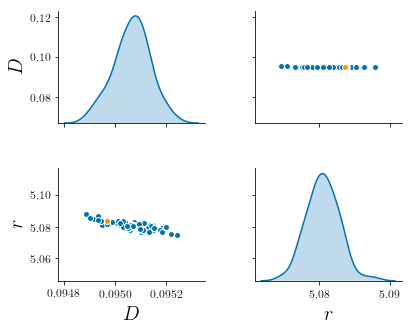

In [36]:
my_model2.plot_bootstrap()